In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import probscale
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [56]:
order_df = pd.read_csv("order_items.csv")
df_test = pd.read_csv("test_trips.csv")
df_train = pd.read_csv("train_trips.csv")
# print(df_train.columns)
# print(order_df.columns)

# 1. Data Cleaning
We need to find the Shopping time which is difference between shopping_ended_at and shopping_started_at.
Extracting Shopping time....

In [57]:
#First, convert datetime strings into datetime

df_train["shopping_started_at"] = pd.to_datetime(df_train["shopping_started_at"], format='%Y-%m-%d %H:%M:%S')
df_train["shopping_ended_at"] = pd.to_datetime(df_train["shopping_ended_at"], format='%Y-%m-%d %H:%M:%S')

df_train['shopping_time'] = pd.to_datetime(df_train['shopping_ended_at'])  - pd.to_datetime(df_train['shopping_started_at']) 

#Convert duration to seconds for easier interpretation

df_train['shopping_time'] = pd.to_timedelta(df_train["shopping_time"]).astype('timedelta64[s]').astype(int)
# df_train.head(5)

### Convert categorical variables to numeric 

In [58]:
# df_train['fulfillment_model'].value_counts()
df_train['fulfillment_model'] = df_train['fulfillment_model'].map({'model_2':2,'model_1':1})

In [59]:
df_test['fulfillment_model'] = df_test['fulfillment_model'].map({'model_2':2,'model_1':1})

In [60]:
store_ids = {1:1, 3:2, 5:3, 6:4, 29:5, 31:6, 54:7, 78:8, 90:9, 105:10, 115:11, 123:12, 126:13, 148:14}

#Convert random store ids variables to sequential store id's
df_train['store_id'] = df_train['store_id'].map(store_ids)

In [61]:
#Convert random store ids variables to sequential store id's
df_test['store_id'] = df_test['store_id'].map(store_ids)

## Extracting Features from Order details ...
1. total_quantity per trip id, 
2. num distict items per trip id,
3. Department wise quantiy per trip id 

In [62]:
# 1. One trip id is having multiple order from multiple deparments . we can have total quantity as one of the feature

total_quantity_trip = order_df.groupby(by=['trip_id'])["quantity"].sum()

# to Convert pd.series into data frame and then inner join to get total quantity for a trip
total_quantity_trip = total_quantity_trip.to_frame().reset_index()

total_quantity_trip.rename(columns={"quantity": "total_quantity"}, inplace=True)
# total_quantity_trip.head()

In [63]:
# 2. Distinct items per trip id 

num_distinct_items_trip = order_df.groupby(by=['trip_id'])["item_id"].nunique()

# to Convert pd.series into data frame and then inner join to get total quantity for a trip
num_distinct_items_trip = num_distinct_items_trip.to_frame().reset_index()

num_distinct_items_trip.rename(columns={"item_id": "distinct_items"}, inplace=True)

# num_distinct_items_trip.head()

In [64]:
# 3. Department wise quantiy per trip id 

num_distinct_department_trip = order_df.groupby(by=['trip_id'])["department_name"].nunique()

# to Convert pd.series into data frame and then inner join to get total quantity for a trip
num_distinct_department_trip = num_distinct_department_trip.to_frame().reset_index()

num_distinct_department_trip.rename(columns={"department_name": "distinct_departments"}, inplace=True)
# num_distinct_department_trip.head()

In [65]:
# Joining all df's 

df_train = pd.merge(df_train, total_quantity_trip,  on = "trip_id",how='inner')
df_train = pd.merge(df_train, num_distinct_items_trip,  on = "trip_id",how='inner')
df_train = pd.merge(df_train, num_distinct_department_trip,  on = "trip_id",how='inner')

In [66]:
# Joining all df's  to Test Set

df_test = pd.merge(df_test, total_quantity_trip,  on = "trip_id",how='inner')
df_test = pd.merge(df_test, num_distinct_items_trip,  on = "trip_id",how='inner')
df_test = pd.merge(df_test, num_distinct_department_trip,  on = "trip_id",how='inner')


In [67]:
#Now construct other variables, like month, date, etc.
df_train["start_month"] = df_train["shopping_started_at"].dt.month
df_train["start_day"] = df_train["shopping_started_at"].dt.day
df_train["start_weekday"] = df_train["shopping_started_at"].dt.weekday 
df_train["start_hour"] = df_train["shopping_started_at"].dt.hour
df_train["start_minute"] = df_train["shopping_started_at"].dt.minute

In [68]:
#Now construct other variables, like month, date, etc.

df_test["shopping_started_at"] = pd.to_datetime(df_test["shopping_started_at"], format='%Y-%m-%d %H:%M:%S')

df_test["start_month"] = df_test["shopping_started_at"].dt.month
df_test["start_day"] = df_test["shopping_started_at"].dt.day
df_test["start_weekday"] = df_test["shopping_started_at"].dt.weekday 
df_test["start_hour"] = df_test["shopping_started_at"].dt.hour
df_test["start_minute"] = df_test["shopping_started_at"].dt.minute

# 2. EDA 

### Distribution of Shopping Time and measure of skewness/Kurtosis

120 10740
No cases with shopping time more than 6000 secs: 2962
% cases with shopping time more than 6000 secs : 2.530261483133014
(117063, 15)
(114101, 15)


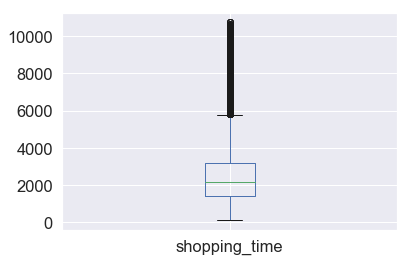

In [69]:
# Getting the variables ready for modelling - Initiall Data Analysis (IDA)
import matplotlib.pyplot as plt
plt.show()
# Looking closely at Dependent Variable - shopping_time

print (df_train['shopping_time'].min(),df_train['shopping_time'].max())

# Consideration 1 - We see that there are some cases with delivery time > 6000 looking at these oultiers below 
df_train.boxplot(column = 'shopping_time')


print ("No cases with shopping time more than 6000 secs: {}".format(len(df_train[df_train['shopping_time']>6000])))

print ("% cases with shopping time more than 6000 secs : {}".format((len(df_train[df_train['shopping_time']>6000])/len(df_train))*100))

print(df_train.shape)

# Removing these cases from the dataset as its fair to assume that these are data log issues as a delivery time cannot be greater
# than 8000 secs.

df_train = df_train[df_train['shopping_time']<=6000]

print(df_train.shape)

In [70]:
df_train['shopping_time'].describe()

count    114101.000000
mean       2333.170787
std        1208.980500
min         120.000000
25%        1440.000000
50%        2100.000000
75%        3060.000000
max        6000.000000
Name: shopping_time, dtype: float64

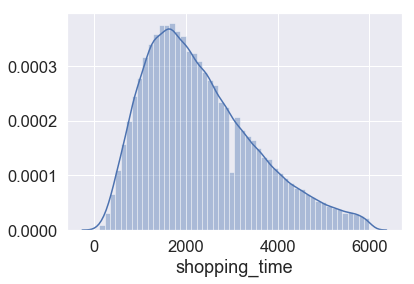

In [71]:
#histogram
sns.distplot(df_train['shopping_time']);

In [72]:
#skewness and kurtosis
print("Skewness: %f" % df_train['shopping_time'].skew())
print("Kurtosis: %f" % df_train['shopping_time'].kurt())

Skewness: 0.733177
Kurtosis: 0.024150


####  data sets with high kurtosis tend to have heavy tails, or outliers and the skewness for a normal distribution is zero, and any symmetric data should have a skewness near zero. The data is moderately skewed

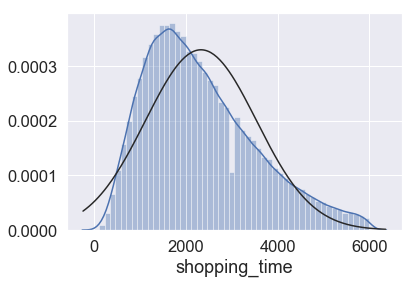

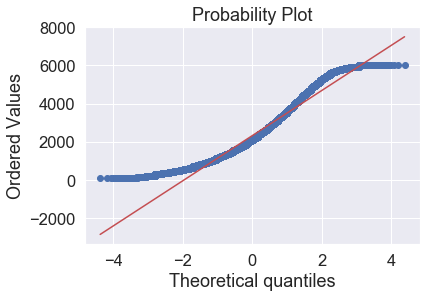

In [73]:
#histogram and normal probability plot
sns.distplot(df_train['shopping_time'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['shopping_time'], plot=plt)

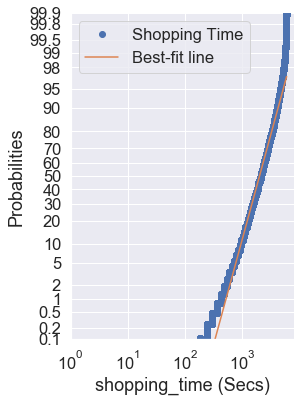

In [74]:
fig, ax = plt.subplots(figsize=(4, 6))
fig = probscale.probplot(df_train['shopping_time'], ax=ax, plottype='prob', probax='y', bestfit=True,
                         datascale='log', problabel='Probabilities', datalabel='shopping_time (Secs)',
                         scatter_kws=dict(label='Shopping Time'),
                         line_kws=dict(label='Best-fit line'))
ax.legend(loc='upper left')
ax.set_ylim(bottom=0.1, top=99.9)
ax.set_xlim(left=1, right=8000)
sns.despine()

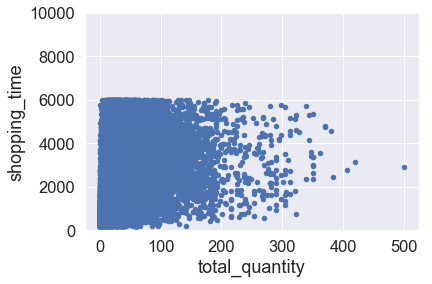

In [75]:
#scatter plot quantity/shoppingtime
var = 'total_quantity'
data = pd.concat([df_train['shopping_time'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='shopping_time', ylim=(0,10000));

### Relationship with categorical features

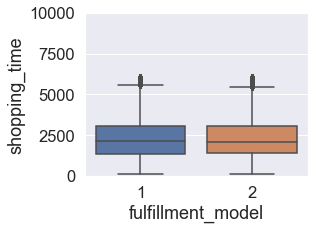

In [76]:
#box plot model/shopping time
var = 'fulfillment_model'
data = pd.concat([df_train['shopping_time'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(4, 3))
fig = sns.boxplot(x=var, y="shopping_time", data=data)
fig.axis(ymin=0, ymax=10000);

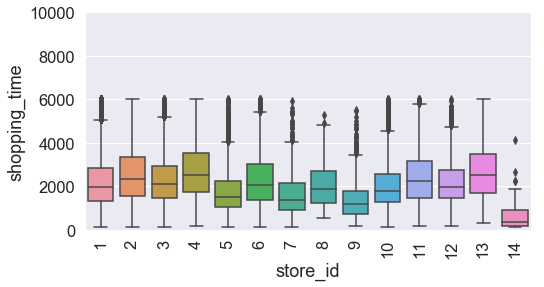

In [77]:
var = 'store_id'
data = pd.concat([df_train['shopping_time'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 4))
fig = sns.boxplot(x=var, y="shopping_time", data=data)
fig.axis(ymin=0, ymax=10000);
plt.xticks(rotation=90);

###### store_ids = {1:1, 3:2, 5:3, 6:4, 29:5, 31:6, 54:7, 78:8, 90:9, 105:10, 115:11, 123:12, 126:13, 148:14}


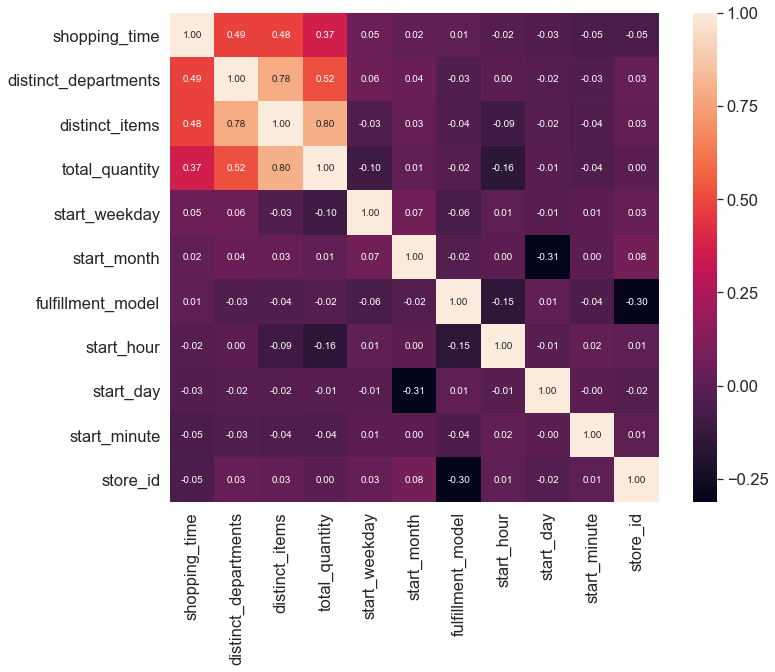

In [78]:
# Removing id's and timestamp (converted it to day/hour/min)
df_train_corr = df_train.drop(["trip_id", "shopper_id", "shopping_started_at", "shopping_ended_at"], axis=1)


#correlation matrix

corrmat = df_train_corr.corr()
f, ax = plt.subplots(figsize=(12, 9))
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'shopping_time')['shopping_time'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.50)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### Missing Values

In [79]:
# missing data in the training 
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(20)

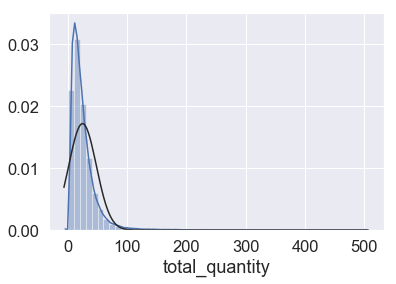

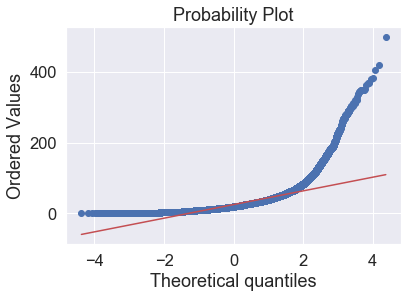

In [80]:
#histogram and normal probability plot
sns.distplot(df_train['total_quantity'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['total_quantity'], plot=plt)

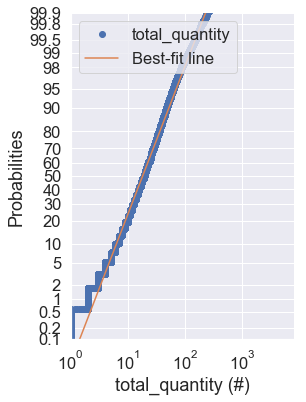

In [81]:
fig, ax = plt.subplots(figsize=(4, 6))
fig = probscale.probplot(df_train['total_quantity'] , ax=ax, plottype='prob', probax='y', bestfit=True,
                         datascale='log', problabel='Probabilities', datalabel='total_quantity (#)',
                         scatter_kws=dict(label='total_quantity'),
                         line_kws=dict(label='Best-fit line'))
ax.legend(loc='upper left')
ax.set_ylim(bottom=0.1, top=99.9)
ax.set_xlim(left=1, right=8000)
sns.despine()

# 2. Modeling 

In [82]:
X = np.log1p(df_train.drop(["shopping_time","trip_id", "shopper_id", "shopping_started_at", "shopping_ended_at"], axis=1))
y = np.log1p(df_train["shopping_time"])


In [83]:
# X.shape # (114101, 10)

In [84]:
# df_train.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

# The error metric: RMSE on the log of the Shopping time.
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [85]:
from sklearn import  linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
Y_pred = regr.predict(X_test)

mean_squared_error(y_true=y_test, y_pred=Y_pred)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, Y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, Y_pred))

Mean squared error: 0.22
Variance score: 0.33


In [86]:
from sklearn.linear_model import Lasso

best_alpha = 0.00099

regr = Lasso(alpha=best_alpha, max_iter=50000)
regr.fit(X_train, y_train)

# Run prediction on training set to get a rough idea of how well it does.
y_pred_lasso = regr.predict(X_test)

print("Lasso score on training set: ", rmse(y_test, y_pred_lasso))

# Run prediction on the test set.
y_pred_lasso = regr.predict(X_test)
print('Lasso Variance score: %.2f' % r2_score(y_test, y_pred_lasso))

Lasso score on training set:  0.46843626997408694
Lasso Variance score: 0.33


In [87]:
from sklearn.metrics import explained_variance_score
explained_variance_score(y_test,Y_pred)

0.32804753816232346

In [88]:
# The error metric: RMSE on the log of the shopping time
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [89]:
import xgboost as xgb
regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.02,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1,
                num_boost_round=999,
                early_stopping_rounds=10)
regr.fit(X_train, y_train)

# Run prediction on training set to get a rough idea of how well it does.
Y_pred = regr.predict(X_test)
print("XGBoost score on training set: ", rmse(y_test, Y_pred))

XGBoost score on training set:  0.4489481979097024


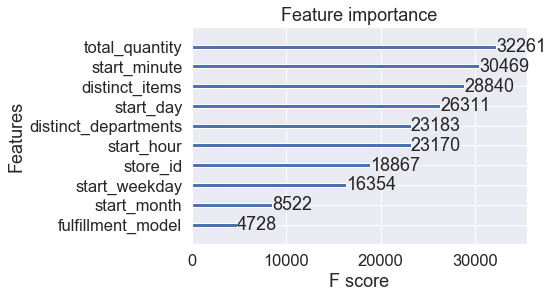

In [ ]:
xgb.plot_importance(regr.get_booster())

In [ ]:
# Run prediction on the test set.
y_pred_xgb = regr.predict(X_test)

print('XGBoost Variance score: %.2f' % r2_score(y_test, y_pred_xgb))

In [ ]:
# XGBoost gave the best performance

In [ ]:
X_TEST = df_test.drop(["trip_id", "shopper_id", "shopping_started_at"], axis=1)

In [ ]:
X_TEST.shape

In [ ]:
# Run prediction on the test set.
y_pred_xgb1 = regr.predict(X_TEST)
y_pred_xgb1 = np.expm1(y_pred_xgb1)

In [ ]:
y_pred_xgb1

In [ ]:
# creating the submission file

from collections import OrderedDict
data = OrderedDict()
data['trip_id'] = df_test.trip_id
data['shopping_time'] = y_pred_xgb1
my_submission = pd.DataFrame(data)
my_submission.to_csv('submission.csv',index=False)